<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Промежуточные-выводы" data-toc-modified-id="Промежуточные-выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточные выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

Проект выполнялся с помощью Google Colab

## Подготовка

In [ ]:
# !pip install spacy -q

In [ ]:
import pandas as pd
import numpy as np
import numpy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    make_scorer
)


from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import transformers


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
RANDOM_STATE = 42
TEST_SIZE=0.25

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Уберем столбец `Unnamed:0`

In [ ]:
data = data.drop(columns=['Unnamed: 0'])

Посмотрим на распределение токсичных/нетоксичных комментариев

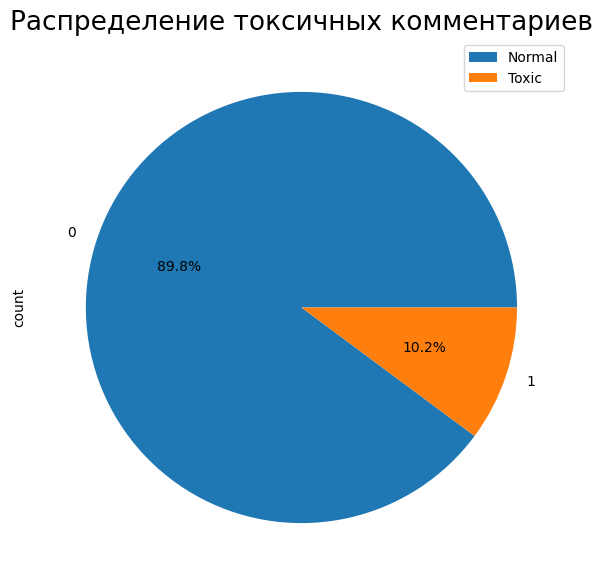

In [ ]:
plt.figure(figsize=(8, 7))
data['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.legend(['Normal', 'Toxic'])
plt.title('Распределение токсичных комментариев', fontsize=19)

plt.show()

Датасет несбалансирован. При обучении на несбалансированных данных модель может стать склонной к предсказанию доминирующего класса, игнорируя меньшинственный класс.

In [ ]:
data = data.sample(n=60000, random_state=42).reset_index(drop=True)

In [ ]:
data.head()

,text,toxic
0,"Sometime back, I just happened to log on to ww...",0
1,"""\n\nThe latest edit is much better, don't mak...",0
2,""" October 2007 (UTC)\n\nI would think you'd be...",0
3,Thanks for the tip on the currency translation...,0
4,I would argue that if content on the Con in co...,0


In [ ]:
def clear_text(text):
    text = text.lower()
    cleaned_text = re.sub(r'(?:\n|\r)', ' ', text)
    cleaned_text = re.sub(r'[^a-zA-Z ]+', '', text).strip()
    return cleaned_text

def lemmatize_text(text):
    doc = nlp(text)

    return ' '.join([token.lemma_ for token in doc])

In [ ]:
data['text'] = data['text'].apply(clear_text)

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

data['lemmatized'] = data['text'].apply(lemmatize_text)

In [ ]:
data[['lemmatized', 'text']].sample(5)

,lemmatized,text
49354,I be confuse as to how I could have be bloke f...,i am confused as to how i could have been blok...
21668,likewise a belate thank you for the admin nomi...,likewise a belated thank you for the admin nom...
35460,tot tv please refrain from add nonsense to wik...,tots tv please refrain from adding nonsense to...
46219,edit to seahawks please be careful not to re...,edit to seahawks please be careful not to rem...
52440,pratyaksh kukreja a creative student of engine...,pratyaksh kukreja a creative student of engine...


In [ ]:
data.to_csv('data_lemmatized', index=False)

### Промежуточные выводы

1. В датасете 159 тыс. строк и 3 столбца. Один из столбцов мы удалили, т.к. он дублировал индекс;
2. Изначально, стоблец `toxic` содержал два значения: 1 и 0 (True и False) в соотношении 10.2% и 89.8% соответственно;
3. Очистили и лемматизировали данные в столбце `text`.

## Обучение

Функция для кросс-валидации

In [ ]:
def rscv(model, grid, njobs):
    random_search = RandomizedSearchCV(
    model,
    grid,
    cv=5,
    n_jobs=njobs,
    scoring='f1'
    )
    random_search.fit(X_train, y_train)
    return (random_search.best_estimator_,
            random_search.best_score_)

Разбиваем датасет на выборки, инициализируем TfidfVectorizer и трансформируем

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data['lemmatized'],
    data['toxic'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [ ]:
stop_words = list(stopwords.words('english'))

In [ ]:
lr_pipe = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')),
    ]
)

dt_pipe = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')),
    ]
)

lgbm_pipe = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')),
    ]
)

### Логистическая регрессия

In [ ]:
lr_grid = {
    'clf__C': range(10, 15)
}

In [ ]:
%%time
logreg_model, logreg_f1 = rscv(lr_pipe, lr_grid, -1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 12.4 s, sys: 7.99 s, total: 20.3 s
Wall time: 2min 46s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('Лучшая модель и её параметры:\n\n', logreg_model)
print('Метрика F1 на тренировочной выборке:', logreg_f1)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(C=14, class_weight='balanced',
                                    random_state=42))])
Метрика F1 на тренировочной выборке: 0.7601415108494374


### DecisionTreeClassifier

In [ ]:
dtc_grid = {
    'clf__max_depth': range(1, 15),
    'clf__min_samples_leaf': range(1, 10)
}

In [ ]:
%%time
dectree_model, dectree_f1 = rscv(dt_pipe, dtc_grid, -1)

CPU times: user 17.5 s, sys: 2.79 s, total: 20.3 s
Wall time: 4min 50s


In [ ]:
print('Лучшая модель и её параметры:\n\n', dectree_model)
print('Метрика F1 на тренировочной выборке:', dectree_f1)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                                        min_samples_leaf=2, random_state=42))])
Метрика F1 на тренировочной выборке: 0.4477561780199788


### LGBMClassifier

In [ ]:
lgbm_grid = {
    'clf__num_leaves': [100, 150],
    'clf__learning_rate': [0.1]
}

In [ ]:
%%time
lgbm_model, lgbm_f1 = rscv(lgbm_pipe, lgbm_grid, 1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3620, number of negative: 32380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.305132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222799
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 4477
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3621, number of negative: 32379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.205159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222754
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 4456
[LightGBM] [

In [ ]:
print('Лучшая модель и её параметры:\n\n', lgbm_model)
print('Метрика F1 на тренировочной выборке:', lgbm_f1)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LGBMClassifier(class_weight='balanced', num_leaves=150,
                                random_state=42))])
Метрика F1 на тренировочной выборке: 0.7492660360781668


### Анализ моделей

Сравним все три модели по метрикам:

In [ ]:
results = pd.DataFrame({
    'LogisticRegression': [logreg_f1],
    'DecisionTreeClassifier': [dectree_f1],
    'LGBMClassifier': [lgbm_f1]
}, index=['F1'])

In [ ]:
results.T

,F1
LogisticRegression,0.760142
DecisionTreeClassifier,0.447756
LGBMClassifier,0.749266


Лучшей моделью оказалась по метрике F1 LGBMClassifier, от нее не сильно отстает логистическая регрессия. Проверим метрику на тестовых данных

In [ ]:
predictions = logreg_model.predict(X_test)

In [ ]:
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print('Метрика F1 равна', f1)

Метрика F1 равна 0.7642743221690589


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Я тут не совсем понял. Я перевел тексты в векторы с помощью TfidfVectorizer, и сейчас использовал predict на "сырых" тестовых данных и это сработало. Не нужно ли мне было переводить тестовые данные в векторы?

</div>

## Выводы

**Подготовка данных:**

В ходе подготовки данных, мы загрузили датасет, состоящий из 159 тыс строк и 3 столбцов, удалили один из них.

Графически описали распределение токсичных комментариев. Сбалансировали датасет, применив downsampling и лемматизировали текст.

**Обучение модели:**

Мы обучили три модели: LogisticRegression, DecisionTreeClassifier и LGBMClassifier. Выбор лучших гиперпараметров осуществлялся за счет **RandomizedSearchCV**. Результаты мы оценивали по двум характеристикам:
1. F1-мера (основная)
2. ROC-AUC (дополнительная)

Результаты:

| Модель                  | F1        |
|-------------------------|-----------|
| LogisticRegression      | 0.760142  |
| DecisionTreeClassifier  | 0.444606  |
| LGBMClassifier          | 0.749266  |




**Лучшей моделью из трех оказалась LightBGM с результатами на тестовой выборке F1 = 0.76**